In [1]:
# Importa la función para la representación de las imágenes
import sys  
sys.path.insert(0, '../')

import resources as src

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model

In [3]:
# Localización de la imagen
img_path = '../data/lineaRuidosa.png'

In [4]:
# Lee la imagen original
ruido_BGR = cv.imread(img_path, cv.IMREAD_COLOR)
ruido_RGB = cv.cvtColor(ruido_BGR, cv.COLOR_BGR2RGB)
ruido_bn = cv.cvtColor(ruido_RGB, cv.COLOR_BGR2GRAY)

In [147]:
# Recorre la imagen extrayendo las coordenadas de 
# los puntos cuyo valor está más próximo a 0 (negro)
# En este caso se opta por los pixeles
# casi negros
columnas = []
filas = []
count = 0
for i in range(ruido_bn.shape[0]):
    for j in range(ruido_bn.shape[1]):
        if ruido_bn[i, j] < 8:
            count = count + 1
            columnas.append(j)
            filas.append(i)

## RANSAC

In [148]:
# Utiliza el modelo de regresión RANSAC
# del paquete SciKit Learn

# Se adecua el dataset para su uso
X = np.array(columnas).reshape(-1, 1)
y = np.array(filas).reshape(-1, 1)

# Crea el modelo de regresión y realiza el ajuste
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)

# Crea las máscaras para los elementos próximos (inliers)
# y los considerados outliers 
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Devuelve la predicción con RANSAC
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y_ransac = ransac.predict(line_X)

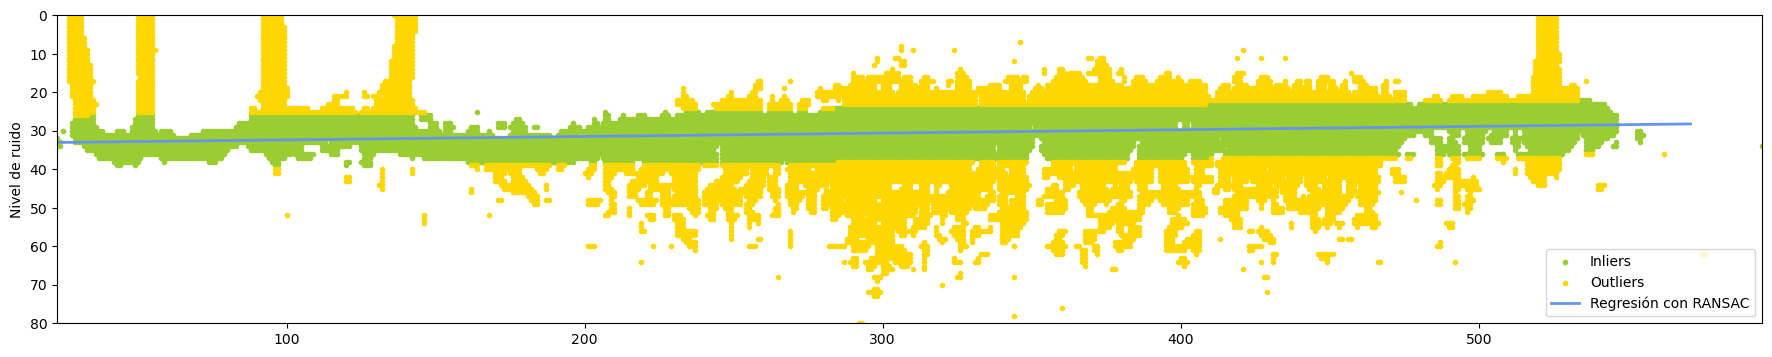

In [149]:
# Representación del resultado de la regresión

# se define una figura ajestada a los límites originales
fig, ax = plt.subplots(figsize=(22, 4))
ax.set(xlim=(X.min(), X.max()), ylim=(y.max(), y.min()))

# Representa los puntos inliers y outliers según las máscaras 
# establecidas por el modelo
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)

# define el grosor de las lineas en la representación
lw = 2

# Representa la línea de regresión obtenida
plt.plot(
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="Regresión con RANSAC",
)

# Establece la leyenda de la figura en la esquina inferior derecha
plt.legend(loc="lower right")
plt.ylabel("Nivel de ruido")

# Para la imagen RANSAC con inliers/outliers
plt.savefig('ransac_noise.png', bbox_inches='tight', dpi=300)

plt.show()

## Hough 

In [21]:
# Función para dibujar las líneas en la imagen a partir de los 
# parámetros obtenidos en cv.HoughLinesP()

from math import dist

def distancia_max(lineas):
    dm = 0
    for i in range(0, len(lineas)):
        l = lineas[i][0]
        a = (l[0], l[1])
        b = (l[2], l[3])
        if dist(a,b) > dm:
            dm = dist(a, b)
            amax = a
            bmax = b
    print(dm)
    return amax, bmax

In [132]:
# Obtiene los bordes a partir de la imagen en escala de grises
ruido_bordes = cv.Canny(ruido_bn, 50, 100, apertureSize=3)

# Calcula las lineas usando el algoritmo Hough mejorado
# lineas_HP = cv.HoughLinesP(ruido_bordes, 1, np.pi / 180, 0, None, 50, 10)
lineas_HP = cv.HoughLinesP(ruido_bordes, 1, np.pi/10  , 45, minLineLength=30, maxLineGap=100)

# lineas_HP = cv.HoughLinesP(ruido_bordes, 
#     1, 
#     np.pi/180, 
#     threshold=50,      # Reducido de 80 a 50
#     minLineLength=100, # Aumentado de 50 a 100
#     maxLineGap=10)     # Reducido de 30 a 10

ruido_con_lineas_HP = np.copy(ruido_RGB)

# Obtiene los puntos inicial y final de la linea más larga
a, b = distancia_max(lineas_HP)

578.0


## Comparación de los resultados

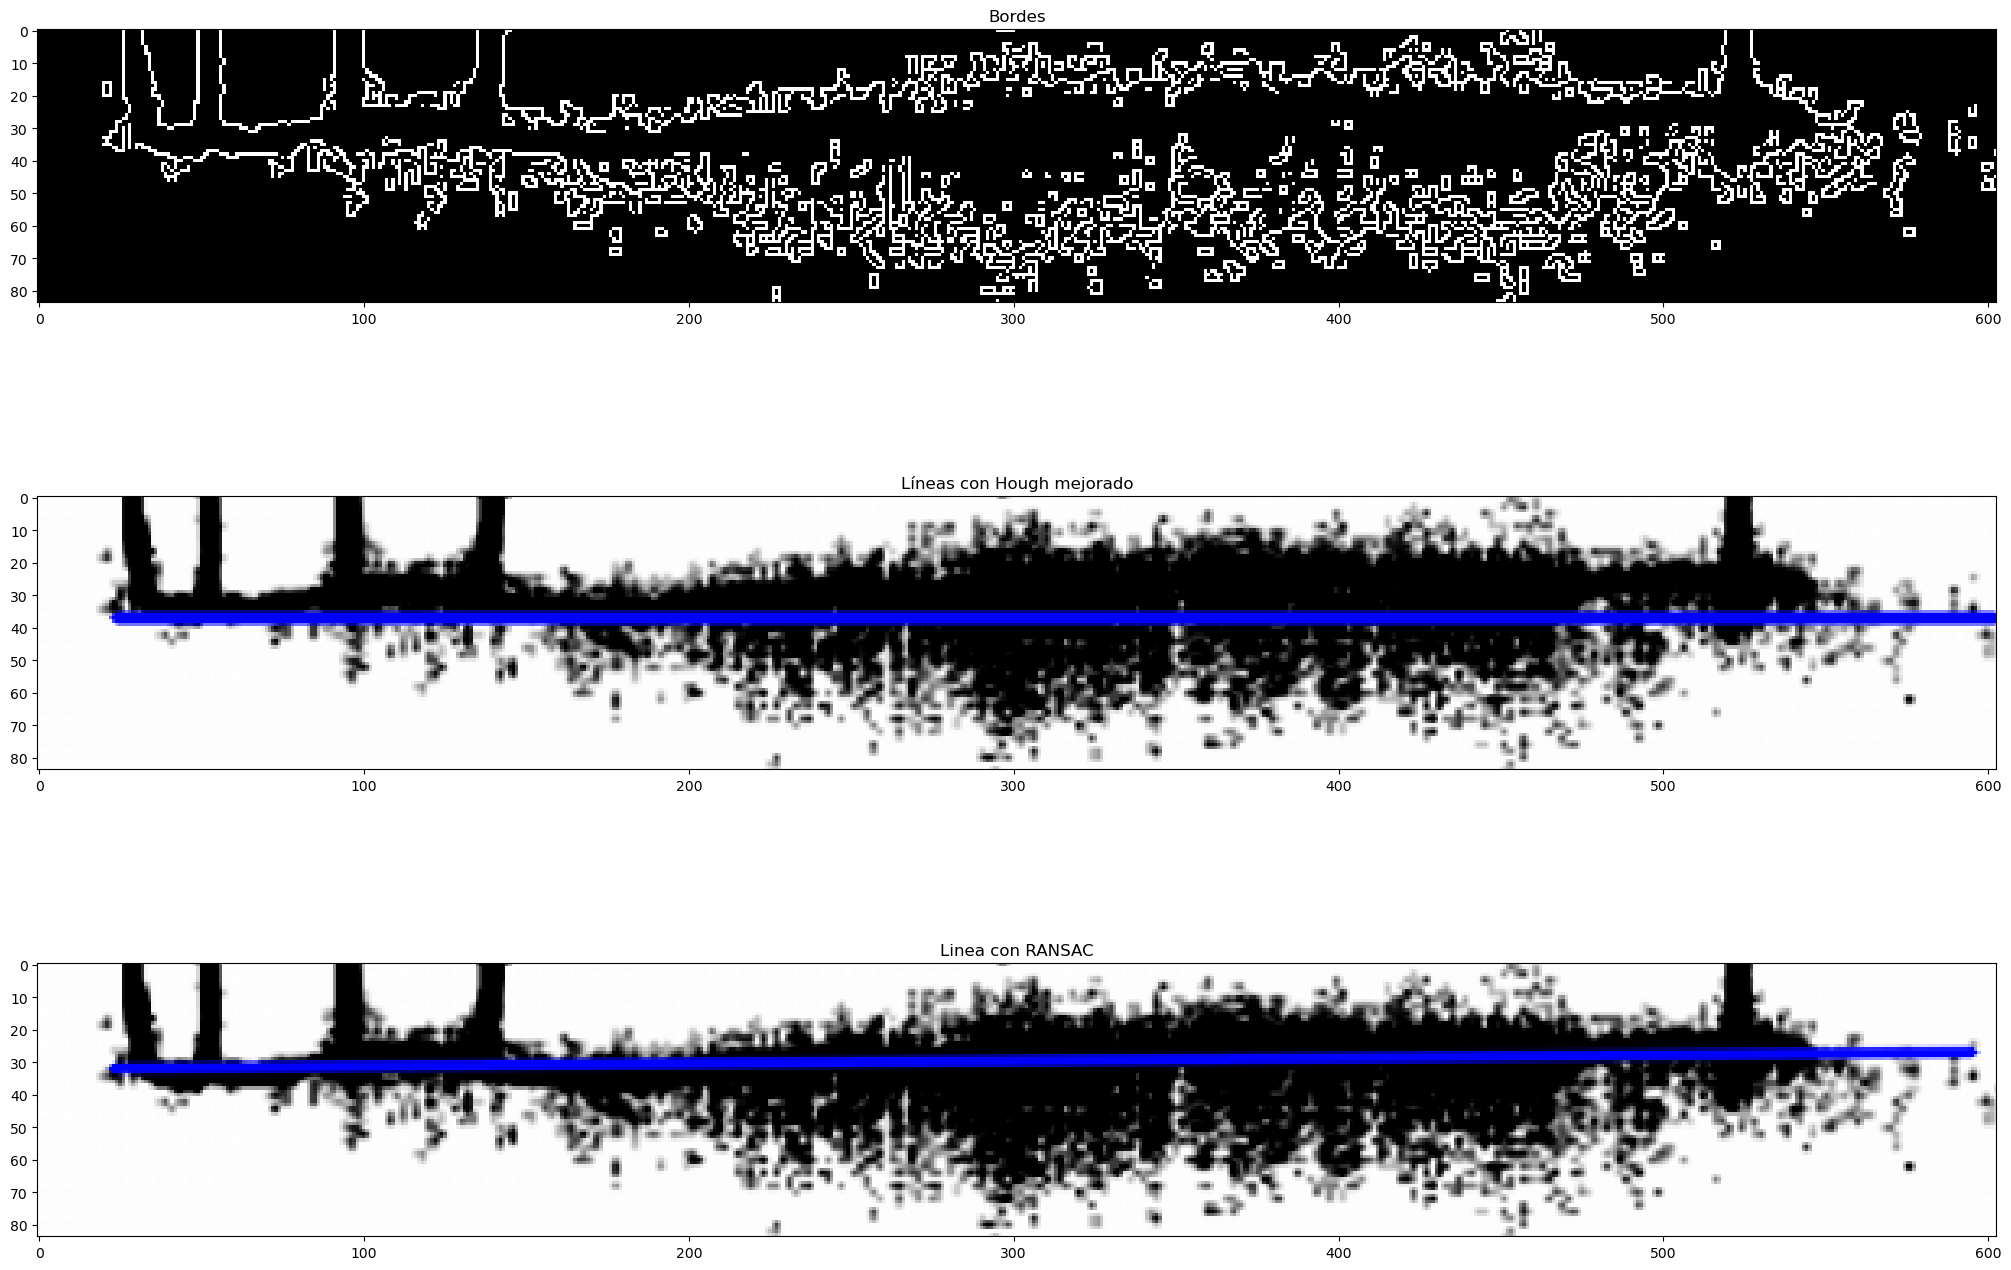

In [135]:
# Coordenadas de la linea de regresión de RANSAC
r0 = round(np.rint(line_y_ransac[0]).item())
r1 = round(np.rint(line_y_ransac[line_y_ransac.size-1]).item())

# Hace una copia de la imagen con ruido RGB
ruido_regresion_RANSAC = ruido_RGB.copy()

# Traza la linea en la imagen
cv.line(ruido_regresion_RANSAC, (X.min(), r0), (X.max(), r1), (0,0,255), 2, cv.LINE_AA)

# Traza la linea más larga obtenida con el algoritmo de Hough
cv.line(ruido_con_lineas_HP, a, b, (0,0,255), 2, cv.LINE_AA)

# Establece los títulos para la representación de las imágenes
titulos = ['Bordes',
           'Líneas con Hough mejorado',
           'Linea con RANSAC']

# Establece las imágenes para los ejes
imagenes = [ruido_bordes, ruido_con_lineas_HP, ruido_regresion_RANSAC]

# Para las comparativas
cv.imwrite('hough_.png', ruido_con_lineas_HP)
cv.imwrite('ransac_.png', ruido_regresion_RANSAC)

# Muestra las imágenes 
# Funcion mostrar imágenes del archivo importado
src.mostrar_imagenes(3, 1, titulos, imagenes, 20, 14, (True, False, False))

In [150]:
# Coordenadas de la linea de regresión de RANSAC
r0 = round(np.rint(line_y_ransac[0]).item())
r1 = round(np.rint(line_y_ransac[line_y_ransac.size-1]).item())

# Crear figura con subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 12))
fig.tight_layout(pad=3.0)

# Bordes
axs[0].imshow(ruido_bordes, cmap='gray')
axs[0].set_title('Bordes')
axs[0].axis('off')

# Hough
axs[1].imshow(ruido_bn, cmap='gray')
axs[1].plot([a[0], b[0]], [a[1], b[1]], 'b-', linewidth=2)
axs[1].set_title('Líneas con Hough mejorado')
axs[1].axis('off')

# RANSAC
axs[2].imshow(ruido_bn, cmap='gray')
axs[2].plot([X.min(), X.max()], [r0, r1], 'b-', linewidth=2)
axs[2].set_title('Línea con RANSAC')
axs[2].axis('off')

# Guardar imágenes individuales y comparativa
plt.savefig('comparativa.png', dpi=300, bbox_inches='tight')

# Guardar imágenes individuales
fig_hough, ax_hough = plt.subplots(figsize=(15, 3))
ax_hough.imshow(ruido_bn, cmap='gray')
ax_hough.plot([a[0], b[0]], [a[1], b[1]], 'b-', linewidth=2)
# ax_hough.set_title('Líneas con Hough mejorado')
ax_hough.axis('off')
plt.savefig('hough_.png', dpi=300, bbox_inches='tight')

fig_ransac, ax_ransac = plt.subplots(figsize=(15, 3))
ax_ransac.imshow(ruido_bn, cmap='gray')
ax_ransac.plot([X.min(), X.max()], [r0, r1], 'b-', linewidth=2)
# ax_ransac.set_title('Línea con RANSAC')
ax_ransac.axis('off')
plt.savefig('ransac_.png', dpi=300, bbox_inches='tight')

plt.close('all')